# Evaluation of Machine Learning Models for Sentiment Analysis

### Imports

In [19]:
import time

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm

# warnings.filterwarnings("ignore")

In [20]:
RF_N_ESTIMATORS = 50  # Random Forest trees
LR_MAX_ITER = 500  # Logistic Regression iterations
SVC_MAX_ITER = 100  # SVM iterations
DT_MAX_DEPTH = 5  # Decision Tree depth
CV_FOLDS = 3  # Cross-validation folds
MAX_FEATURES = 5000  # BoW features

## Preprocessing Steps

In [21]:
df = pd.read_csv("data/reviews_sample_processed.csv")

### Label Encoding

This step converts 'positive' and 'negative' labels into numerical values (0 and 1).

In [22]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["label"])

In [23]:
print(
    f"Label encoding: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}"
)

Label encoding: {'negative': np.int64(0), 'positive': np.int64(1)}


### Bag of Words (BoW) Matrix Creation

This step converts the text data into a numerical format based on frequency of words.

In [24]:
vectorizer = CountVectorizer(
    max_features=MAX_FEATURES,
    min_df=2,  # Ignore terms that appear in less than 2 documents
    max_df=0.95,  # Ignore terms that appear in more than 95% of documents
    stop_words="english",
)

X = vectorizer.fit_transform(df["text"])

In [25]:
print(f"BoW matrix shape: {X.shape}")

BoW matrix shape: (69903, 5000)


### Splitting the Data

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [27]:
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (55922, 5000)
Test set shape: (13981, 5000)


## Training and Evaluating Models

In [28]:
results = {}


def get_result(y_test, y_pred):
    return {
        "test_accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average="weighted"),
        "recall": recall_score(y_test, y_pred, average="weighted"),
        "f1_score": f1_score(y_test, y_pred, average="weighted"),
        "predictions": y_pred,
        "positive_precision": precision_score(
            y_test, y_pred, pos_label=1, average="binary"
        ),
        "positive_recall": recall_score(y_test, y_pred, pos_label=1, average="binary"),
        "positive_f1_score": f1_score(y_test, y_pred, pos_label=1, average="binary"),
        "negative_precision": precision_score(
            y_test, y_pred, pos_label=0, average="binary"
        ),
        "negative_recall": recall_score(y_test, y_pred, pos_label=0, average="binary"),
        "negative_f1_score": f1_score(y_test, y_pred, pos_label=0, average="binary"),
    }


base_classifiers = {
    "Decision Tree": DecisionTreeClassifier(random_state=42, max_depth=DT_MAX_DEPTH),
    "Logistic Regression": LogisticRegression(
        random_state=42, max_iter=LR_MAX_ITER, verbose=1
    ),
    "SVM": SVC(
        random_state=42,
        max_iter=SVC_MAX_ITER,
        probability=True,
        kernel="linear",
        verbose=True,
    ),
}

### Random Forest

In [29]:
start_time = time.time()

rf_clf = RandomForestClassifier(
    n_estimators=RF_N_ESTIMATORS, random_state=42, max_depth=DT_MAX_DEPTH, verbose=1
)

rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

results["Random Forest"] = get_result(y_test, y_pred_rf)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


### Soft Voting (Averaged Voting)

In [38]:
soft_voting_clf = VotingClassifier(
    estimators=[
        ("dt", base_classifiers["Decision Tree"]),
        ("lr", base_classifiers["Logistic Regression"]),
        ("svm", base_classifiers["SVM"]),
    ],
    voting="soft",
)
soft_voting_clf.fit(X_train, y_train)
y_pred_soft = soft_voting_clf.predict(X_test)

results["Averaged Voting"] = get_result(y_test, y_pred_soft)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.025088, rho = 0.706018
nSV = 195, nBSV = 0
Total nSV = 195
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -8.606189, rho = 0.678301
nSV = 199, nBSV = 0
Total nSV = 199
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.082056, rho = 0.940233
nSV = 195, nBSV = 0
Total nSV = 195
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.935078, rho = 0.899133
nSV = 193, nBSV = 0
Total nSV = 193
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.967616, rho = 0.380767
nSV = 194, nBSV = 0
Total nSV = 194
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.822860, rho = 0.983328
nSV = 198, nBSV = 0
Total nSV = 198


### Hard Voting (Majority Voting)

In [39]:
hard_voting_clf = VotingClassifier(
    estimators=[
        ("dt", base_classifiers["Decision Tree"]),
        ("lr", base_classifiers["Logistic Regression"]),
        ("svm", base_classifiers["SVM"]),
    ],
    voting="hard",
)
hard_voting_clf.fit(X_train, y_train)
y_pred_hard = hard_voting_clf.predict(X_test)

results["Majority Voting"] = get_result(y_test, y_pred_hard)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.025088, rho = 0.706018
nSV = 195, nBSV = 0
Total nSV = 195
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -8.606189, rho = 0.678301
nSV = 199, nBSV = 0
Total nSV = 199
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.082056, rho = 0.940233
nSV = 195, nBSV = 0
Total nSV = 195
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.935078, rho = 0.899133
nSV = 193, nBSV = 0
Total nSV = 193
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.967616, rho = 0.380767
nSV = 194, nBSV = 0
Total nSV = 194
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.822860, rho = 0.983328
nSV = 198, nBSV = 0
Total nSV = 198


### Weighted Voting

In [40]:
cv_scores = {}
for name, clf in tqdm(base_classifiers.items(), desc="CV Scoring"):
    scores = cross_val_score(clf, X_train, y_train, cv=CV_FOLDS, scoring="accuracy")
    cv_scores[name] = scores.mean()

# Normalize weights
total_score = sum(cv_scores.values())
weights = [
    cv_scores["Decision Tree"] / total_score,
    cv_scores["Logistic Regression"] / total_score,
    cv_scores["SVM"] / total_score,
]

weighted_voting_clf = VotingClassifier(
    estimators=[
        ("dt", base_classifiers["Decision Tree"]),
        ("lr", base_classifiers["Logistic Regression"]),
        ("svm", base_classifiers["SVM"]),
    ],
    voting="soft",
    weights=weights,
)
weighted_voting_clf.fit(X_train, y_train)
y_pred_weighted = weighted_voting_clf.predict(X_test)

results["Weighted Voting"] = get_result(y_test, y_pred_weighted)

CV Scoring:  33%|███▎      | 1/3 [00:00<00:01,  1.76it/s][Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
CV Scoring:  67%|██████▋   | 2/3 [00:01<00:00,  1.19it/s]

[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -8.703758, rho = 0.671195
nSV = 196, nBSV = 0
Total nSV = 196
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -8.229745, rho = 0.627930
nSV = 195, nBSV = 0
Total nSV = 195
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -9.900354, rho = 0.687802
nSV = 197, nBSV = 0
Total nSV = 197
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -8.835204, rho = 0.567349
nSV = 196, nBSV = 0
Total nSV = 196
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.716500, rho = 0.669582
nSV = 193, nBSV = 1
Total nSV = 193
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -8.270682, rho = 0.644997
nSV = 198, nBSV = 0
Total nSV = 198
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -8.889357, rho = 0.906439
nSV = 197, nBSV = 0
Total nSV = 197
WARN

CV Scoring: 100%|██████████| 3/3 [00:33<00:00, 11.14s/it]
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.025088, rho = 0.706018
nSV = 195, nBSV = 0
Total nSV = 195
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -8.606189, rho = 0.678301
nSV = 199, nBSV = 0
Total nSV = 199
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.082056, rho = 0.940233
nSV = 195, nBSV = 0
Total nSV = 195
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.935078, rho = 0.899133
nSV = 193, nBSV = 0
Total nSV = 193
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.967616, rho = 0.380767
nSV = 194, nBSV = 0
Total nSV = 194
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.822860, rho = 0.983328
nSV = 198, nBSV = 0
Total nSV = 198


## Results Summary and Visualization

In [50]:
results_df = pd.DataFrame(results).T
results_df = results_df[
    [
        "test_accuracy",
        "precision",
        "recall",
        "f1_score",
        "positive_precision",
        "positive_recall",
        "positive_f1_score",
        "negative_precision",
        "negative_recall",
        "negative_f1_score",
    ]
]
results_df.columns = [
    "Accuracy",
    "Precision",
    "Recall",
    "F1-Score",
    "Positive Precision",
    "Positive Recall",
    "Positive F1-Score",
    "Negative Precision",
    "Negative Recall",
    "Negative F1-Score",
]
results_df = results_df.reset_index().rename(columns={"index": "Model"})
results_df = results_df.round(4)

In [51]:
results_df

,Model,Accuracy,Precision,Recall,F1-Score,Positive Precision,Positive Recall,Positive F1-Score,Negative Precision,Negative Recall,Negative F1-Score
0,Random Forest,0.689793,0.778217,0.689793,0.580932,0.684268,0.999148,0.812259,0.97037,0.057068,0.107797
1,Averaged Voting,0.855089,0.865139,0.855089,0.845702,0.835826,0.975932,0.900462,0.925091,0.607929,0.733701
2,Majority Voting,0.773121,0.792341,0.773121,0.741599,0.758738,0.970927,0.851817,0.861069,0.368547,0.516168
3,Weighted Voting,0.870539,0.875902,0.870539,0.864377,0.856203,0.970181,0.909636,0.916193,0.666739,0.77181


### Plots

#### Confusion Matrices

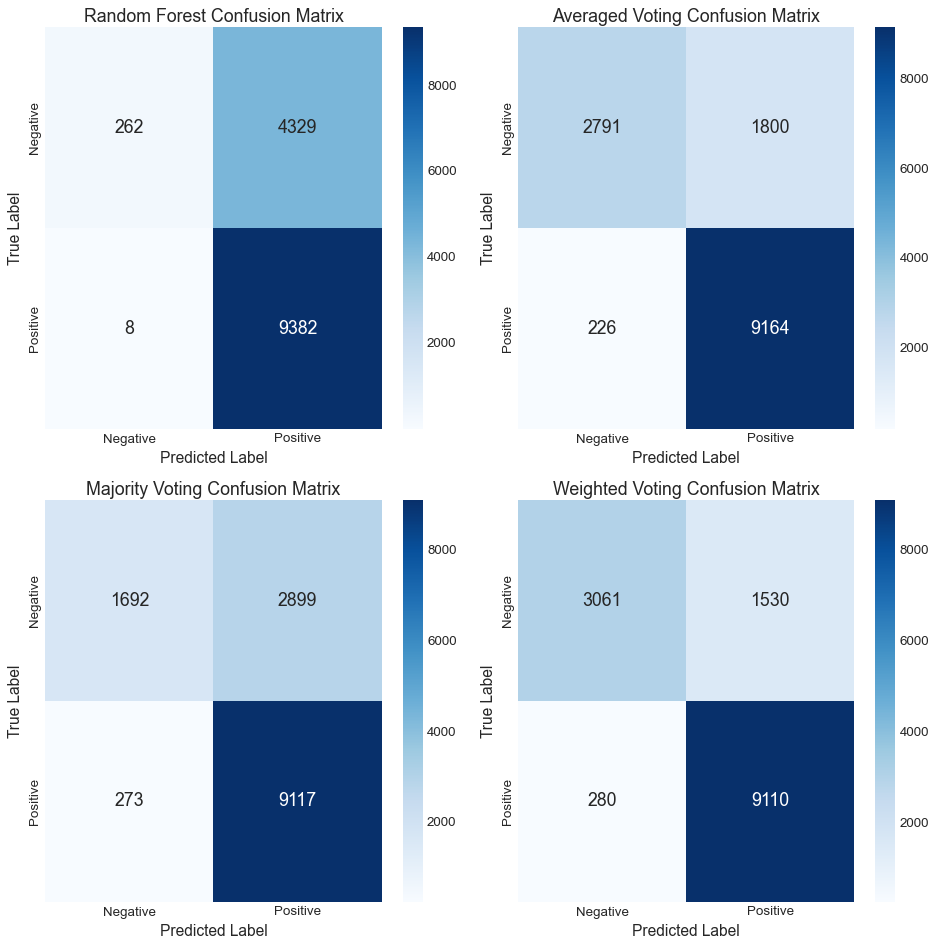

In [74]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

for i, (model_name, result) in enumerate(results.items()):
    ax = axes[i // 2, i % 2]
    cm = confusion_matrix(y_test, result["predictions"])
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        ax=ax,
        annot_kws={"size": 16},
    )
    ax.set_title(f"{model_name} Confusion Matrix", fontsize=16)
    ax.set_xlabel("Predicted Label", fontsize=14)
    ax.set_ylabel("True Label", fontsize=14)
    ax.set_xticklabels(["Negative", "Positive"], fontsize=12)
    ax.set_yticklabels(["Negative", "Positive"], fontsize=12)


plt.tight_layout()
plt.show()

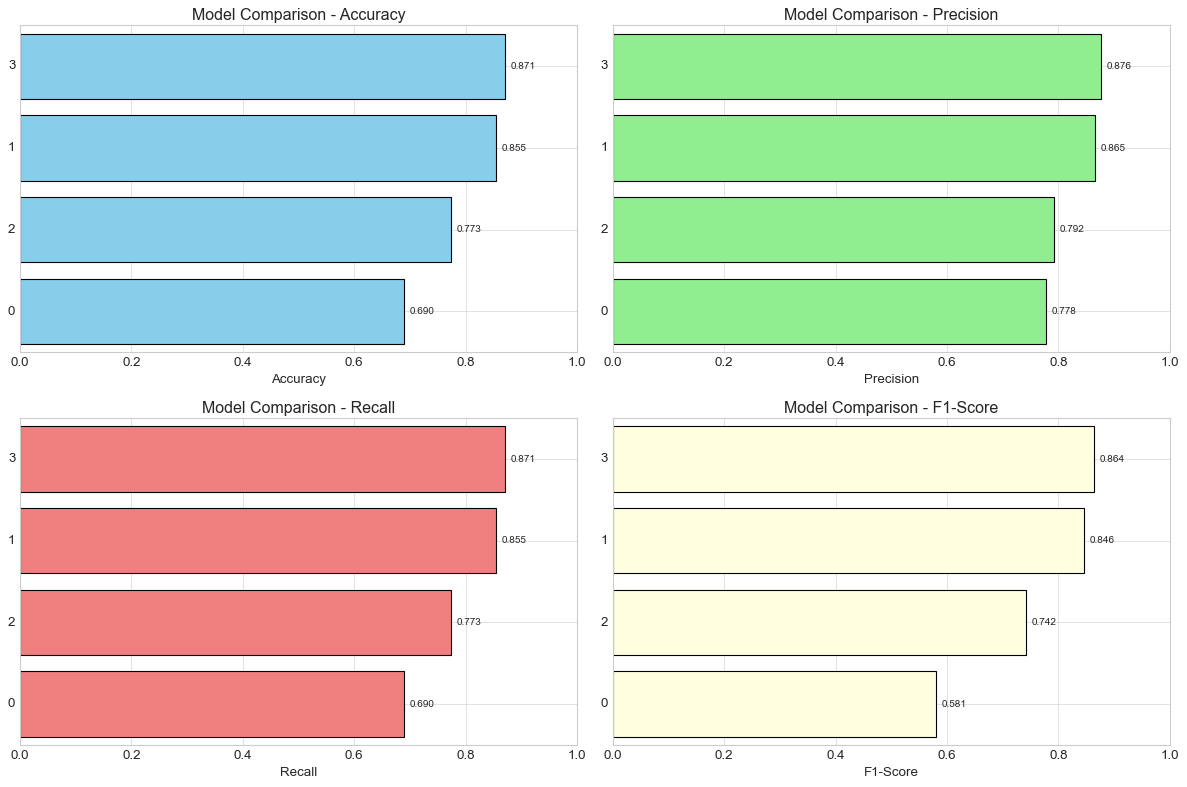

In [85]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
colors = ["skyblue", "lightgreen", "lightcoral", "lightyellow"]

for i, metric in enumerate(metrics):
    ax = axes[i // 2, i % 2]

    sorted_data = results_df.sort_values(metric, ascending=True)

    bars = ax.barh(range(len(sorted_data)), sorted_data[metric], color=colors[i])
    ax.set_yticks(range(len(sorted_data)))
    ax.set_yticklabels(sorted_data.index)
    ax.set_xlabel(metric)
    ax.set_title(f"Model Comparison - {metric}")
    ax.set_xlim(0, 1)

    # Add value labels on bars
    for j, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(
            width + 0.01,
            bar.get_y() + bar.get_height() / 2,
            f"{width:.3f}",
            ha="left",
            va="center",
            fontsize=9,
        )

plt.tight_layout()
plt.show()